# Biyolojik İşaretlerin İşlenmesi Projesi – EEG ile Epileptik Nöbet Tespiti

## 🔹 Proje Kurulumu: Gerekli Kütüphaneler

Bu hücre, analiz için gerekli tüm kütüphaneleri yükler.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns 

# Uyarıları bastır
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 🔹 Adım 1: Veri Yükleme ve Ön İnceleme



Bu adımda, "Epileptic Seizure Recognition" veri seti `.csv` dosyasından yüklenir ve yapısını anlamak için ilk birkaç satır (`.head()`) ve sütun bilgileri (`.info()`) incelenir.

In [ ]:

file_path = r"C:\Users\nevra\Desktop\221229058_NevraNurDogan_1Bproje\epilepsi\Epileptic Seizure Recognition.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Veri seti '{file_path}' başarıyla yüklendi. Boyut: {df.shape}")
    
    print("\n--- Veri Seti İlk 5 Satır (Head) ---")
    print(df.head())
    
    print("\n--- Veri Seti Bilgisi (Info) ---")
    df.info()
    
except FileNotFoundError:
    print(f"HATA: '{file_path}' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")

Veri seti 'C:\Users\nevra\Desktop\Belgeler\Yazılım Mühendisliği\Yazılım Mühendisliği 4.Sınıf\Biyomedikal\Ödev 1\epilepsi\Epileptic Seizure Recognition.csv' başarıyla yüklendi. Boyut: (11500, 180)

--- Veri Seti İlk 5 Satır (Head) ---
      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5

## 🔹 Adım 2: Veri Ön İşleme


Veri seti üzerinde gerekli ön işlemler yapılır:
1.  **Eksik (NaN) ve Yinelenen (Duplicate) Veri Kontrolü:** Veri bütünlüğü sağlanır.
2.  **Hedef Değişken (y) Oluşturma:** Problem, çok sınıflı (1-5) bir yapıdan ikili (binary) bir sınıflandırma problemine (1: Nöbet, 0: Nöbet Değil) dönüştürülür.
3.  **Veri Bölünmesi (Train/Test Split):** Veri seti, %80 eğitim ve %20 test olarak `stratify` (sınıf dağılımını koruyarak) parametresi ile bölünür.

In [3]:
nan_count = df.isnull().sum().sum()
dup_count = df.duplicated().sum()
print(f"Eksik Değer (NaN) sayısı: {nan_count}")
print(f"Yinelenen Satır sayısı: {dup_count}")

df['y_binary'] = np.where(df['y'] == 1, 1, 0)
y = df['y_binary']
print(f"\nHedef değişken 'y_binary' oluşturuldu. Sınıf dağılımı:\n{y.value_counts()}")

signal_cols = [col for col in df.columns if col.startswith('X')]
X = df[signal_cols]
print(f"\nToplam {len(signal_cols)} adet sinyal sütunu bulundu ve 'X' olarak atandı.")
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

print(f"\nVeri bölündü:")
print(f"Eğitim Seti (X_train) Boyutu: {X_train.shape}")
print(f"Test Seti (X_test) Boyutu: {X_test.shape}")
print(f"Eğitim Etiketleri (y_train) Dağılımı:\n{y_train.value_counts(normalize=True)}")
print(f"Test Etiketleri (y_test) Dağılımı:\n{y_test.value_counts(normalize=True)}")

Eksik Değer (NaN) sayısı: 0
Yinelenen Satır sayısı: 0

Hedef değişken 'y_binary' oluşturuldu. Sınıf dağılımı:
y_binary
0    9200
1    2300
Name: count, dtype: int64

Toplam 178 adet sinyal sütunu bulundu ve 'X' olarak atandı.

Veri bölündü:
Eğitim Seti (X_train) Boyutu: (9200, 178)
Test Seti (X_test) Boyutu: (2300, 178)
Eğitim Etiketleri (y_train) Dağılımı:
y_binary
0    0.8
1    0.2
Name: proportion, dtype: float64
Test Etiketleri (y_test) Dağılımı:
y_binary
0    0.8
1    0.2
Name: proportion, dtype: float64


### 2.1. Örnek Sinyal Görselleştirmesi

Raporlama ve sunum için eğitim setinden rastgele bir "Normal Sinyal" (Sınıf 0) ve bir "Nöbet Sinyali" (Sınıf 1) seçilerek görselleştirilir. Bu, iki sınıf arasındaki belirgin farkı görmemizi sağlar.

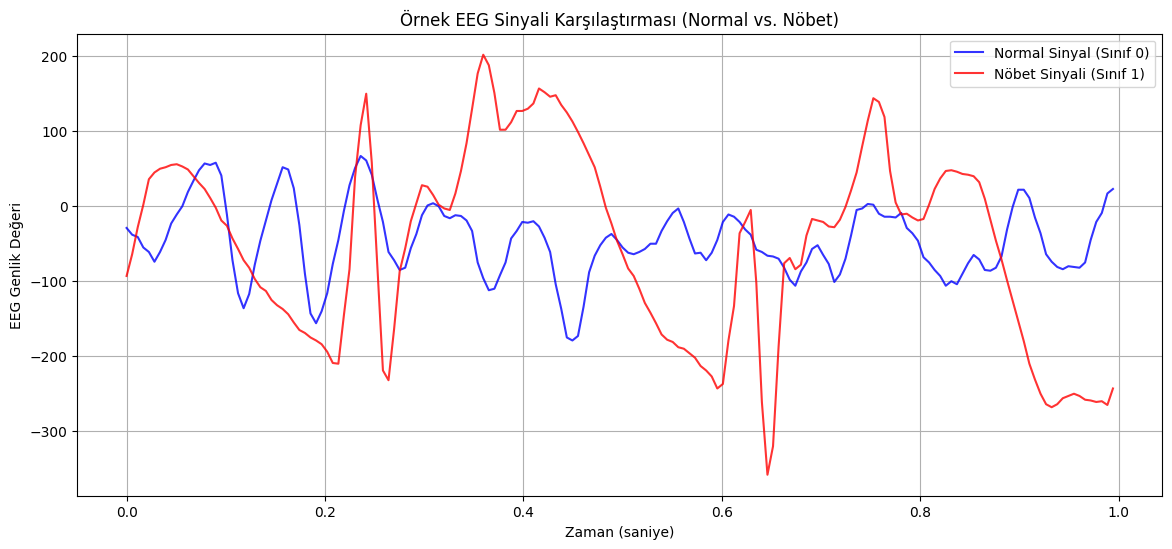

In [4]:
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

normal_signal_sample = X_train_float[y_train == 0].iloc[0]
seizure_signal_sample = X_train_float[y_train == 1].iloc[0]

time = np.arange(len(normal_signal_sample)) / 178.0 

plt.figure(figsize=(14, 6))
plt.plot(time, normal_signal_sample, label='Normal Sinyal (Sınıf 0)', alpha=0.8, color='blue')
plt.plot(time, seizure_signal_sample, label='Nöbet Sinyali (Sınıf 1)', alpha=0.8, color='red')
plt.title('Örnek EEG Sinyali Karşılaştırması (Normal vs. Nöbet)')
plt.xlabel('Zaman (saniye)')
plt.ylabel('EEG Genlik Değeri')
plt.legend()
plt.grid(True)
plt.savefig("ornek_sinyal_grafiği.png")
plt.show()

## 🔹 Adım 3: Özellik Çıkarımı (Feature Engineering)

Klasik makine öğrenmesi (RF, SVM) ve özellik-tabanlı CNN modelleri için, 178 noktalı ham sinyal segmentlerinden anlamlı özellikler çıkarılır.

Bu adım iki bölümden oluşur:
1.  **Zaman-Domeni Özellikleri:** `mean`, `std`, `var`, `min`, `max`, `skew`, `kurtosis`
2.  **Frekans-Domeni Özellikleri:** FFT (Hızlı Fourier Dönüşümü) kullanılarak `delta`, `theta`, `alpha`, `beta`, `gamma` bantlarının ortalama güçleri.

In [5]:
def extract_features(data):
    features_df = pd.DataFrame()
    
    features_df['mean'] = data.mean(axis=1)
    features_df['std'] = data.std(axis=1)
    features_df['var'] = data.var(axis=1)
    features_df['min'] = data.min(axis=1)
    features_df['max'] = data.max(axis=1)
    features_df['skew'] = data.apply(skew, axis=1)
    features_df['kurt'] = data.apply(kurtosis, axis=1)
    
    N = 178 
    Fs = 178 
    freq_bins = np.fft.rfftfreq(N, 1/Fs)
  
    delta_band = (freq_bins >= 0.5) & (freq_bins < 4)
    theta_band = (freq_bins >= 4) & (freq_bins < 8)
    alpha_band = (freq_bins >= 8) & (freq_bins < 12)
    beta_band = (freq_bins >= 12) & (freq_bins < 30)
    gamma_band = (freq_bins >= 30) & (freq_bins < 89) 
    
    fft_results = np.abs(np.fft.rfft(data.values, axis=1))
    
    features_df['delta_power'] = fft_results[:, delta_band].mean(axis=1)
    features_df['theta_power'] = fft_results[:, theta_band].mean(axis=1)
    features_df['alpha_power'] = fft_results[:, alpha_band].mean(axis=1)
    features_df['beta_power'] = fft_results[:, beta_band].mean(axis=1)
    features_df['gamma_power'] = fft_results[:, gamma_band].mean(axis=1)
    
    return features_df

print("Özellik çıkarım fonksiyonu (extract_features) tanımlandı.")

Özellik çıkarım fonksiyonu (extract_features) tanımlandı.


In [6]:
print("Özellik çıkarımı yapılıyor (RF, SVM ve CNN-Özellik için)...")
X_train_features = extract_features(X_train_float)
X_test_features = extract_features(X_test_float)

print(f"Özellik çıkarımı tamamlandı. Yeni özellik sayısı: {X_train_features.shape[1]}")

print("\n--- Rapor için Çıkarılan Özelliklerin Listesi ---")
feature_list = X_train_features.columns.tolist()
for i, feature in enumerate(feature_list):
    print(f"  {i+1}. {feature}")

print("\n--- Özellik Seti (İlk 5 Satır) ---")
print(X_train_features.head())

Özellik çıkarımı yapılıyor (RF, SVM ve CNN-Özellik için)...
Özellik çıkarımı tamamlandı. Yeni özellik sayısı: 12

--- Rapor için Çıkarılan Özelliklerin Listesi ---
  1. mean
  2. std
  3. var
  4. min
  5. max
  6. skew
  7. kurt
  8. delta_power
  9. theta_power
  10. alpha_power
  11. beta_power
  12. gamma_power

--- Özellik Seti (İlk 5 Satır) ---
           mean        std          var    min    max      skew      kurt  \
2214 -45.443820  48.603779  2362.327334 -179.0   67.0 -0.038277  0.080962   
5847  31.741573  53.432153  2854.994985  -85.0  151.0  0.388405 -0.697880   
6840 -14.988764  29.499016   870.191963  -74.0   49.0  0.074896 -0.850147   
5958 -21.443820  63.597069  4044.587221 -223.0  127.0 -0.463674  0.239093   
4938  -1.679775  69.331625  4806.874278 -153.0  139.0  0.075267 -0.902253   

      delta_power  theta_power  alpha_power  beta_power  gamma_power  
2214  1083.119339  1202.999325   989.584841  704.260606    61.744904  
5847  2034.499225  1881.397862  1457.88089

### 3.1. Özellikleri Ölçeklendirme (StandardScaler)

Özellikler çıkarıldıktan sonra, SVM ve CNN gibi mesafeye duyarlı algoritmaların performansını artırmak için `StandardScaler` (Z-skoru normalizasyonu) ile ölçeklendirilir.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

print("Özellikler StandardScaler ile ölçeklendi (Ortalama=0, Std=1).")
print(f"X_train_scaled boyutu: {X_train_scaled.shape}")

Özellikler StandardScaler ile ölçeklendi (Ortalama=0, Std=1).
X_train_scaled boyutu: (9200, 12)


## 🔹 Adım 4: Klasik Makine Öğrenmesi (Özellikler ile)

Bu adımda, **ölçeklendirilmiş özellikler** kullanılarak iki klasik ML modeli eğitilir.

### Model 1: Random Forest (Özellik Çıkarımlı)

In [8]:
print("Model 1: Random Forest (Özellik Çıkarımlı) eğitiliyor...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest modeli eğitildi.")

Model 1: Random Forest (Özellik Çıkarımlı) eğitiliyor...
Random Forest modeli eğitildi.


### Model 2: SVM (Özellik Çıkarımlı)

In [9]:
print("Model 2: SVM (Özellik Çıkarımlı) eğitiliyor...")
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True) 
svm_model.fit(X_train_scaled, y_train)
print("SVM modeli eğitildi.")

Model 2: SVM (Özellik Çıkarımlı) eğitiliyor...
SVM modeli eğitildi.


## 🔹 Adım 5: Derin Öğrenme (Özellikler ile)

Bu adımda, **ölçeklendirilmiş 12 özellik** kullanılarak bir derin öğrenme modeli (1D-CNN) eğitilir. Bu, klasik ML modelleriyle doğrudan bir karşılaştırma sağlar.

### Model 3: 1D-CNN (Özellik Çıkarımlı)

In [10]:
X_train_cnn_feat = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn_feat = np.expand_dims(X_test_scaled, axis=-1)
print(f"CNN-Özellik için veri yeniden şekillendirildi: {X_train_cnn_feat.shape}")

input_shape_features = (X_train_cnn_feat.shape[1], 1) 
cnn_model_features = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape_features),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

cnn_model_features.compile(optimizer='adam', 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])

print("\n--- Model 3 Mimarisi (CNN-Özellik) ---")
cnn_model_features.summary()

CNN-Özellik için veri yeniden şekillendirildi: (9200, 12, 1)

--- Model 3 Mimarisi (CNN-Özellik) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         8,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,357 (32.64 KB)

 Trainable params: 8,293 (32.39 KB)

 Non-trainable params: 64 (256.00 B)

In [11]:
print("Model 3 (1D-CNN - Özellik Çıkarımlı) eğitiliyor...")
history_feat = cnn_model_features.fit(
    X_train_cnn_feat, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)
print("Model 3 (1D-CNN - Özellik Çıkarımlı) eğitildi.")

Model 3 (1D-CNN - Özellik Çıkarımlı) eğitiliyor...
Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9588 - loss: 0.1340 - val_accuracy: 0.9457 - val_loss: 0.1504
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.0778 - val_accuracy: 0.9658 - val_loss: 0.0801
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0637 - val_accuracy: 0.9717 - val_loss: 0.0655
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0621 - val_accuracy: 0.9745 - val_loss: 0.0591
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0545 - val_accuracy: 0.9799 - val_loss: 0.0564
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9804 - loss: 0.0529 - val_accuracy: 0.9788 - val_loss: 0.0543
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0534 - val_accuracy: 0.9815 - val_loss: 0.0535
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

## 🔹 Adım 6: Derin Öğrenme (Ham Veri ile)

Bu adımda, **hiç özellik çıkarımı yapılmadan**, 178 zaman noktasından oluşan **ham EEG sinyalleri** doğrudan 1D-CNN modeline verilir. Bu, "Uçtan-Uca" (End-to-End) öğrenme yaklaşımıdır.

### Model 4: 1D-CNN (Ham Veri)

In [12]:
X_train_cnn_raw = np.expand_dims(X_train_float.values, axis=-1)
X_test_cnn_raw = np.expand_dims(X_test_float.values, axis=-1)
print(f"CNN-HamVeri için veri yeniden şekillendirildi: {X_train_cnn_raw.shape}")

input_shape_raw = (X_train_cnn_raw.shape[1], 1) 

cnn_model_raw = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape_raw),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

cnn_model_raw.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

print("\n--- Model 4 Mimarisi (CNN-Ham Veri) ---")
cnn_model_raw.summary()

CNN-HamVeri için veri yeniden şekillendirildi: (9200, 178, 1)

--- Model 4 Mimarisi (CNN-Ham Veri) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 176, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 176, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       256,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,137 (1.10 MB)

 Trainable params: 287,689 (1.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
print("Model 4 (1D-CNN - Ham Veri) eğitiliyor...")
history_raw = cnn_model_raw.fit(
    X_train_cnn_raw, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)
print("Model 4 (1D-CNN - Ham Veri) eğitildi.")

Model 4 (1D-CNN - Ham Veri) eğitiliyor...
Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9466 - loss: 0.1747 - val_accuracy: 0.9457 - val_loss: 0.1185
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9673 - loss: 0.0954 - val_accuracy: 0.9707 - val_loss: 0.0646
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9700 - loss: 0.0905 - val_accuracy: 0.9609 - val_loss: 0.0913
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9731 - loss: 0.0788 - val_accuracy: 0.9717 - val_loss: 0.0704
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9810 - loss: 0.0541 - val_accuracy: 0.9696 - val_loss: 0.0712
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9821 - loss: 0.0545 - val_accuracy: 0.9793 - val_loss: 0.0566
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9821 - loss: 0.0537 - val_accuracy: 0.9755 - val_loss: 0.0513
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy

## 🔹 Adım 7: Model Değerlendirme ve Karşılaştırma

Tüm 4 model (RF-Özellik, SVM-Özellik, CNN-Özellik, CNN-HamVeri) test seti üzerinde değerlendirilir ve sonuçları karşılaştırılır.

### 7.1. Test Seti Tahminleri

In [14]:
print("Tüm 4 model için test seti tahminleri yapılıyor...")

y_pred_rf = rf_model.predict(X_test_scaled)

y_pred_svm = svm_model.predict(X_test_scaled)

y_pred_prob_cnn_feat = cnn_model_features.predict(X_test_cnn_feat)
y_pred_cnn_features = (y_pred_prob_cnn_feat > 0.5).astype(int).flatten()

y_pred_prob_cnn_raw = cnn_model_raw.predict(X_test_cnn_raw)
y_pred_cnn_raw = (y_pred_prob_cnn_raw > 0.5).astype(int).flatten()

print("Tahminler tamamlandı.")

Tüm 4 model için test seti tahminleri yapılıyor...
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Tahminler tamamlandı.


### 7.2. Karşılaştırma Metrikleri ve Tablosu

In [15]:
def calculate_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = 0, 0, 0, 0
    if cm.shape == (2, 2): TN, FP, FN, TP = cm.ravel()
    else: 
        if 0 in y_true or 0 in y_pred: TN = cm[0,0]
        if 1 in y_true or 1 in y_pred: TP = cm[1,1]
        
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    return {
        'Model': model_name, 
        'Accuracy': accuracy, 
        'Sensitivity (Recall)': sensitivity, 
        'Specificity': specificity, 
        'F1-Score': f1,
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
    }

rf_metrics = calculate_metrics(y_test, y_pred_rf, "Random Forest (Özellik Çıkarımlı)")
svm_metrics = calculate_metrics(y_test, y_pred_svm, "SVM (Özellik Çıkarımlı)")
cnn_feat_metrics = calculate_metrics(y_test, y_pred_cnn_features, "1D-CNN (Özellik Çıkarımlı)")
cnn_raw_metrics = calculate_metrics(y_test, y_pred_cnn_raw, "1D-CNN (Ham Veri)")

results_df = pd.DataFrame([rf_metrics, svm_metrics, cnn_feat_metrics, cnn_raw_metrics])

print("\n--- PERFORMANS KARŞILAŞTIRMA TABLOSU (RAPOR BÖLÜM 5) ---")

try:
    print(results_df[['Model', 'Accuracy', 'Sensitivity (Recall)', 'Specificity', 'F1-Score']].to_markdown(index=False, floatfmt=".4f"))
except ImportError:
    print(results_df[['Model', 'Accuracy', 'Sensitivity (Recall)', 'Specificity', 'F1-Score']])


--- PERFORMANS KARŞILAŞTIRMA TABLOSU (RAPOR BÖLÜM 5) ---
| Model                             |   Accuracy |   Sensitivity (Recall) |   Specificity |   F1-Score |
|:----------------------------------|-----------:|-----------------------:|--------------:|-----------:|
| Random Forest (Özellik Çıkarımlı) |     0.9839 |                 0.9609 |        0.9897 |     0.9598 |
| SVM (Özellik Çıkarımlı)           |     0.9830 |                 0.9609 |        0.9886 |     0.9577 |
| 1D-CNN (Özellik Çıkarımlı)        |     0.9804 |                 0.9696 |        0.9832 |     0.9520 |
| 1D-CNN (Ham Veri)                 |     0.9870 |                 0.9457 |        0.9973 |     0.9667 |


### 7.3. Görsel Karşılaştırma - Metrikler

Model karşılaştırma grafiği oluşturuluyor...


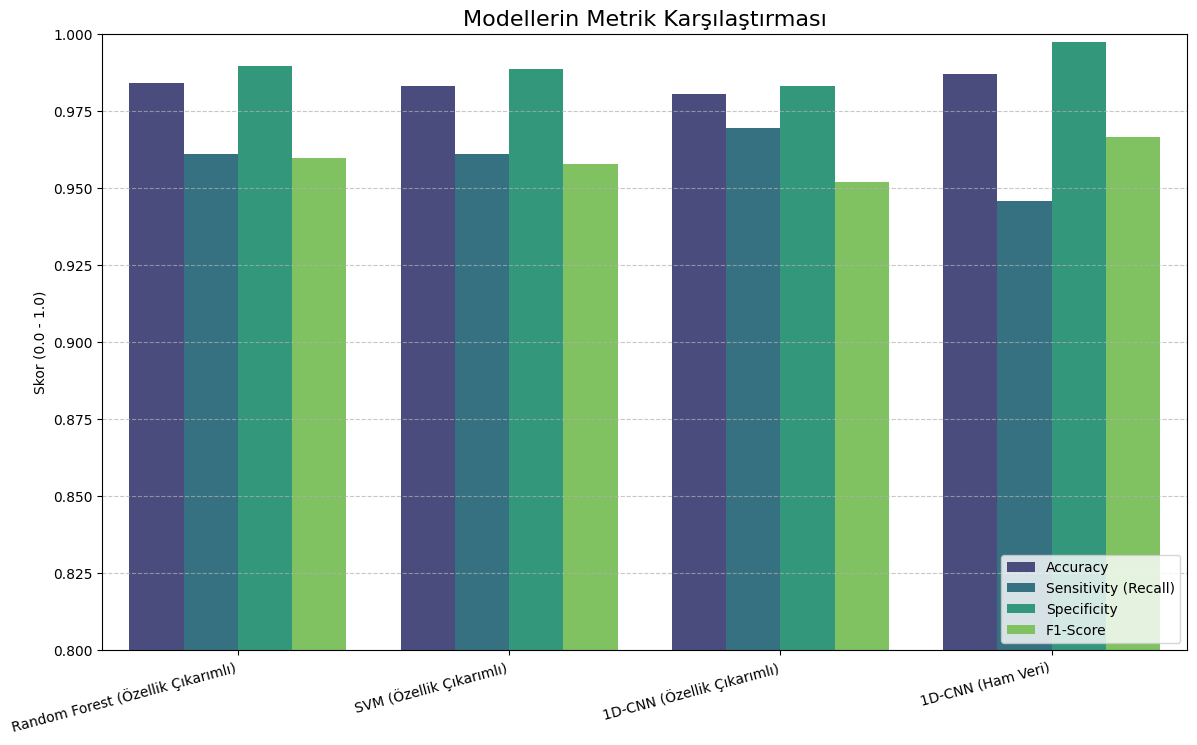

In [16]:
print("Model karşılaştırma grafiği oluşturuluyor...")
try:
    df_melted = results_df.melt('Model', var_name='Metrik', value_name='Skor')
    
    df_plot = df_melted[df_melted['Metrik'].isin(['Accuracy', 'F1-Score', 'Sensitivity (Recall)', 'Specificity'])]

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Model', y='Skor', hue='Metrik', data=df_plot, palette='viridis')
    plt.title('Modellerin Metrik Karşılaştırması', fontsize=16)
    plt.ylabel('Skor (0.0 - 1.0)')
    plt.xlabel('')
    plt.xticks(rotation=15, ha='right')
    plt.ylim(0.8, 1.0) 
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("model_karsilastirma_grafiği.png")
    plt.show()
except ImportError:
    print("HATA: 'seaborn' kütüphanesi kurulu değil. Bu grafik çizilemedi.")

### 7.4. Görsel Karşılaştırma - Sınıflandırma Raporları

In [17]:
print("\n--- DETAYLI SINIFLANDIRMA RAPORLARI (RAPOR BÖLÜM 5) ---")
target_names = ['Nöbet Değil (0)', 'Nöbet Var (1)']

print("\nRandom Forest Raporu (Özellik Çıkarımlı):")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print("\nSVM Raporu (Özellik Çıkarımlı):")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

print("\n1D-CNN Raporu (Özellik Çıkarımlı):")
print(classification_report(y_test, y_pred_cnn_features, target_names=target_names))

print("\n1D-CNN Raporu (Ham Veri):")
print(classification_report(y_test, y_pred_cnn_raw, target_names=target_names))



--- DETAYLI SINIFLANDIRMA RAPORLARI (RAPOR BÖLÜM 5) ---

Random Forest Raporu (Özellik Çıkarımlı):
                 precision    recall  f1-score   support

Nöbet Değil (0)       0.99      0.99      0.99      1840
  Nöbet Var (1)       0.96      0.96      0.96       460

       accuracy                           0.98      2300
      macro avg       0.97      0.98      0.97      2300
   weighted avg       0.98      0.98      0.98      2300


SVM Raporu (Özellik Çıkarımlı):
                 precision    recall  f1-score   support

Nöbet Değil (0)       0.99      0.99      0.99      1840
  Nöbet Var (1)       0.95      0.96      0.96       460

       accuracy                           0.98      2300
      macro avg       0.97      0.97      0.97      2300
   weighted avg       0.98      0.98      0.98      2300


1D-CNN Raporu (Özellik Çıkarımlı):
                 precision    recall  f1-score   support

Nöbet Değil (0)       0.99      0.98      0.99      1840
  Nöbet Var (1)       0.94

### 7.5. Görsel Karşılaştırma - Karışıklık Matrisleri (Confusion Matrices)


Karışıklık Matrisi (Confusion Matrix) grafikleri oluşturuluyor...


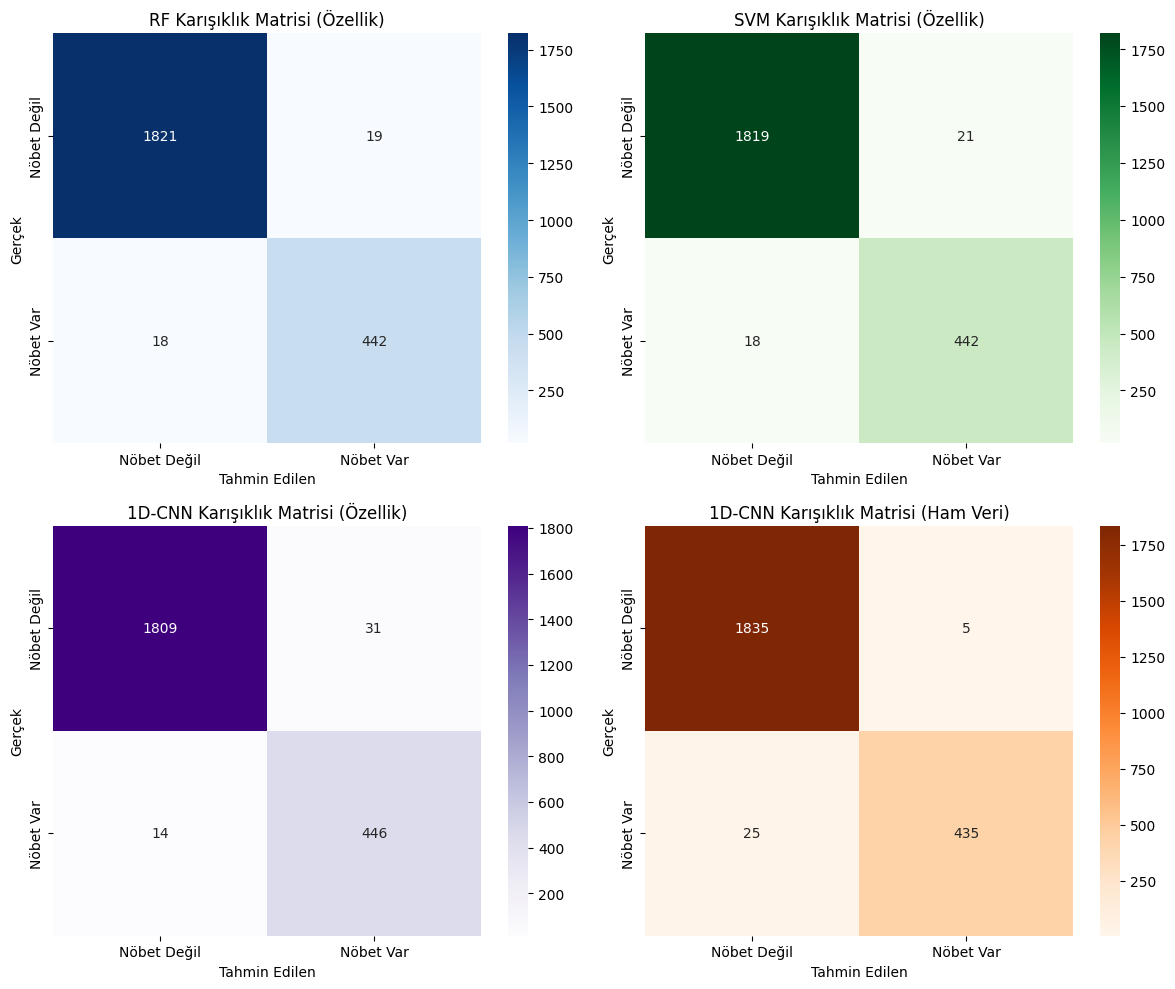

In [18]:
print("\nKarışıklık Matrisi (Confusion Matrix) grafikleri oluşturuluyor...")
try:
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    cm_cnn_feat = confusion_matrix(y_test, y_pred_cnn_features)
    cm_cnn_raw = confusion_matrix(y_test, y_pred_cnn_raw)
    
    plt.figure(figsize=(12, 10))
    labels = ['Nöbet Değil', 'Nöbet Var']
    
    plt.subplot(2, 2, 1)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('RF Karışıklık Matrisi (Özellik)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.subplot(2, 2, 2)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.title('SVM Karışıklık Matrisi (Özellik)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.subplot(2, 2, 3)
    sns.heatmap(cm_cnn_feat, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
    plt.title('1D-CNN Karışıklık Matrisi (Özellik)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.subplot(2, 2, 4)
    sns.heatmap(cm_cnn_raw, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
    plt.title('1D-CNN Karışıklık Matrisi (Ham Veri)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.tight_layout()
    plt.savefig("karisiklik_matrisleri_4model.png")
    plt.show()
except ImportError:
    print("HATA: 'seaborn' kütüphanesi kurulu değil. Karışıklık matrisleri çizilemedi.")

### 7.6. Görsel Karşılaştırma - CNN Eğitim Grafikleri


CNN Eğitim Grafikleri oluşturuluyor...


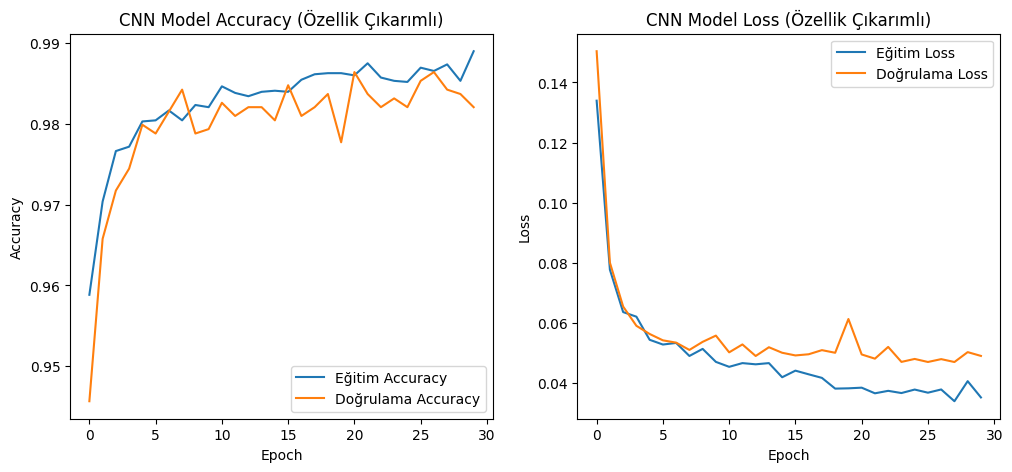

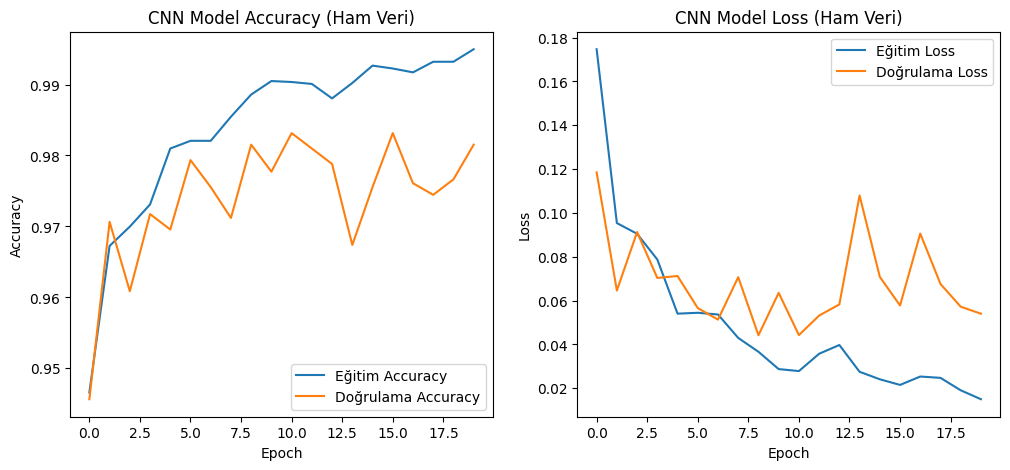

In [ ]:
try:
    print("\nCNN Eğitim Grafikleri oluşturuluyor...")
    
    # 1D-CNN (Özellik Çıkarımlı) Eğitim Grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_feat.history['accuracy'], label='Eğitim Accuracy')
    plt.plot(history_feat.history['val_accuracy'], label='Doğrulama Accuracy')
    plt.title('CNN Model Accuracy (Özellik Çıkarımlı)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_feat.history['loss'], label='Eğitim Loss')
    plt.plot(history_feat.history['val_loss'], label='Doğrulama Loss')
    plt.title('CNN Model Loss (Özellik Çıkarımlı)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("cnn_ozellik_egitim_grafiği.png")
    plt.show()

    # 1D-CNN (Ham Veri) Eğitim Grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_raw.history['accuracy'], label='Eğitim Accuracy')
    plt.plot(history_raw.history['val_accuracy'], label='Doğrulama Accuracy')
    plt.title('CNN Model Accuracy (Ham Veri)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_raw.history['loss'], label='Eğitim Loss')
    plt.plot(history_raw.history['val_loss'], label='Doğrulama Loss')
    plt.title('CNN Model Loss (Ham Veri)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("cnn_ham_veri_egitim_grafiği.png")
    plt.show()
    
except Exception as e:
    print(f"\nUYARI: CNN grafiği çizilemedi: {e}")